In [71]:
import graphviz

In [105]:
def fresh(n):
    return list([str(random.randint(0,1e9)) for i in range(n)])
def idd(n):
    def res(g):
        nodes = fresh(n)
        for node in nodes:
            g.node(node, shape="point")
        return nodes, nodes
    return res
def compose(g, f):
    def res(G):
        a, b = f(G)
        b1, c = g(G)
        assert(len(b) == len(b1))
        G.edges(zip(b,b1))
        return a, c
    return res
def par(f, g): #otimes
    def res(G):     
        a, b = f(G)
        c, d = g(G)
        return a + c, b + d
    return res
'''def fst(n,m):
    def res(G):
        
        a, b
    return res
'''

'''def dump(n, m):
    def res(G):
        nodes = fresh(n)
        for node in nodes:
            G.node(node, shape="point")
        
        return nodes, nodes[:m] + nodes[m+1:]
    return res
'''

def dump():
    def res(G):
        node = fresh(1)[0]
        G.node(node, shape="point", fillcolor="white")
        return [node], []
    return res
def dup():
    def res(G):
        node = fresh(1)[0]
        G.node(node, shape="point")
        return [node], [node, node]
    return res
def converse(f):
    def res(G):
        a, b = f(G)
        return b, a
    return res


It does kind of feel like I'd benefit from an AST. Does sympy have one?
I could use a decorator to attach composition and par as operators.
Or I could wrap the thing in a class.


In [72]:
dot = graphviz.Digraph(comment='The Round Table')
#compose(idd(3),idd(3))(dot)
#z = compose(idd(3),idd(3))
#q = par(z,z)
#res = compose(q, q)

#res(dot)

compose(par(dump(),idd(1)), compose(idd(2),dup()))(dot)

dot

NameError: name 'compose' is not defined

In [166]:
import random
import graphviz
class GraphCat():
    GC = GraphCat
    def __init__(self,res): # just hold the graphviz processor function
        self.res = res
    def fresh(n): # makes random numbers for fresh node labels
        return list([str(random.randint(0,1e9)) for i in range(n)])
    def idd(): # identity morhism. 1 input 1 output.
        def res(g):
            #nodes = GC.fresh(n)
            node = GC.fresh(1)[0]
            #for node in nodes:
            g.node(node, shape="point")
            return [node], [node]
        return GraphCat(res)
    def compose(g, f): # compose morphisms. Makes graphviz edges between node labels generated by g and f
        f = f.res
        g = g.res
        def res(G):
            a, b = f(G)
            b1, c = g(G)
            assert(len(b) == len(b1))
            G.edges(zip(b,b1))
            return a, c
        return GraphCat(res)
    def par(f, g): #monoidal product. Puts f and g in parallel
        f = f.res
        g = g.res
        def res(G):     
            a, b = f(G)
            c, d = g(G)
            return a + c, b + d
        return GraphCat(res)
    def dump(): # dump deletes this edge with an empty circle
        def res(G):
            node = GC.fresh(1)[0]
            G.node(node, shape="point", fillcolor="white")
            return [node], []
        return GraphCat(res)
    def dup(): # duplicate this edge
        def res(G):
            node = GC.fresh(1)[0]
            G.node(node, shape="point", fillcolor="green")
            return [node], [node, node]
        return GraphCat(res)
    def converse(f): # turn input to output of this combinator
        f = f.res
        def res(G):
            a, b = f(G)
            return b, a
        return GraphCat(res)
    def named_simple(name): # a simple labeled 1 input 1 output object
        def res(G):
            node = GC.fresh(1)[0]
            G.node(node,name)
            return [node], [node]   
        return GraphCat(res)
    def block(name, inputs, outputs): # an object with labelled ports
        inputs_label = [f"<{inp}> {inp}" for inp in inputs]
        outputs_label = [f"<{outp}> {outp}" for outp in outputs]
        #return  # use graphviz to build block with label and n ports
        def res(G):
            node = GC.fresh(1)[0]
            inputs1 = [f"{node}:{inp}" for inp in inputs]
            outputs1 = [f"{node}:{outp}" for outp in outputs]
            grphstring = "{ {" + " | ".join(inputs_label) + "} | " + name + " | {"  + "|".join(outputs_label) + "} }"
            G.node(node,grphstring, shape="record")
            return inputs1, outputs1
        return GC(res)
    def fst(): # project out first par of tuple. semnatically equal to (id * dump)
        return GraphCat.block("fst", ["a","b"], ["a1"])
    def snd(): # dump * id
        return GraphCat.block("fst", ["a","b"], ["b1"])
    def run(self): # will run the object on a fresh graphviz object
        dot = graphviz.Digraph()
        dot.format = 'svg'
        self.res(dot)
        return dot
    def __matmul__(self, rhs): # matrix multiplication is a natural analog of composition
        return GC.compose(self, rhs)
    def __mul__(self, rhs): # monoidal product
        return GC.par(self, rhs)
    def __add__(self,rhs): # hmm. What should addition be? Join?
        pass
    def const(label): # inject a constant in. A labelled node with 1 outport and no input
        def res(G):
            node = GraphCat.fresh(1)[0]
            G.node(node, str(label))
            return [], [node]
        return GC(res)
    def cup(): 
        def res(G):
            nodes = GraphCat.fresh(2)
            for node in nodes:
                G.node(node, shape="point")
            G.edge(nodes[0],nodes[1])
            return [], nodes
        return GraphCat(res)
    def cap():
        return GraphCat.converse(GraphCat.cup())

        
            
# class stuff is just so I can get operator overloading


In [170]:
cup = GraphCat.cup()
cap = GraphCat.cap()
I = GraphCat.idd()
d =  cap @ (I * I) @ cup  #(I * cap) @ (I * I * I) @ (cup * I) 
d = d.run()
d.format = "svg"
d.render("cupcap")

['207202065', '352210217']
['264989493', '893601321']
['601677038', '452264168']
['207202065', '352210217']


'cupcap.svg'

In [171]:
GC = GraphCat
plus = GraphCat.block("+", ["a","b"], ["c"])
I = GraphCat.idd()
diagram = plus @ (plus * I) 
p1 = plus
p2 = p1 @ (p1 * p1)
p3 = p1 @ (p2 * p2)
p4 = p1 @ (p3 * p3)

d = p4.run()
d.format = "png"
d.render("adders")


'adders.png'

In [173]:
d = plus @ (GC.const(1) * GC.const(2))
d = d.run()
d.format = "png"
d.render("adders")

'adders.png'

['450257802', '450257802']
['171924041:a', '171924041:b']


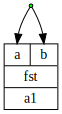

In [136]:
fst = GraphCat.fst()
snd = GraphCat.fst()
d =  fst @ dup
d.run()

In [174]:
GC = GraphCat
f = GraphCat.named_simple("f")
g = GraphCat.named_simple("g")
I = GraphCat.idd()
dump = GC.dump()
dup = GC.dup()
diagram = ((f * I) @ dup @ g @ (dump * I)  @ (I * f) @ (f * f)) * g
d = diagram.run()

d.format = "png"
d.render("randomstuff")
    

'randomstuff.png'

In [95]:
GC = GraphCat
(GC.idd() @ GC.idd()).run()
(GC.idd() * GC.idd()).run()

['833860904']
['621500616']


In [1]:
list(range(3,2*3))

[3, 4, 5]

In [ ]:
class FinVect(np.ndarray):

    def compose(f,g):
        return f @ g
    def idd(n):
        return np.eye(n)
    def par(f,g):
        return np.kron(f,g)
    def __mult__(self,rhs):
        return np.kron(f,g)
    

In [36]:
import scipy.sparse as sp
class LinRel(): #subclass Cat? 
    def __init__(self, m, inputs, outputs):
        self.inputs = inputs # list of indices for []
        self.outputs = outputs
        self.m = m
        #self.v = v # offsets
        #self.outputs = output
        # also might want to track labels for indices.
    def shift(f, n):
        return [i + n for i in f]
    def idd(n):
        I = sp.identity(n)
        inputs = list(range(n))
        outputs = list(range(n, 2*n))
        return LinRel(sp.bmat([[I,-I]]), inputs, outputs)
    def compose(f,g):
        a = len(f.inputs)
        b = len(f.outputs)
        b1 = len(g.inputs)
        assert(b == b1)
        c = len(g.outputs)
        m = sp.bmat( [[f.m, None], [None ,g.m ]]) # this is direct sum
        gi = [i + f.m.shape[1] for i in g.inputs] # shift indices of second
        go = [i + f.m.shape[1] for i in g.outputs]
        constraints = sp.lil_matrix((b, a + b + b1 + c))
        constraints[range(b), f.outputs] = 1 
        constraints[range(b), gi] = -1 
        
        #constraint = sp.hstack(  p1, -p2 )
        return LinRel(sp.bmat([[m], [constraints]]) , f.inputs, go) #np.vstack(f.v,g.v, np.zeros(b))
    def par(f,g):
        m = sp.bmat( [[f.m, None], [None , g.m ]])
        gi = [i + f.m.shape[1] for i in g.inputs] # shift indices of second
        go = [i + f.m.shape[1] for i in g.outputs]
        return LinRel(m,  f.inputs + gi, f.outputs + go) # np.vstack(f.v, g.v) ,
    def __matmul__(self,rhs):
        return LinRel.compose(self,rhs)
    def join(f,g): # meet and join become more complex. We may have a permutation.
        pass# can I even express join? Seems hard, yeah.
    def meet(f,g):
        pass
    # do we even want this direct representation anyway?
        

In [43]:
x= LinRel.idd(3)
print(LinRel.compose(x,x).m.toarray())
print(LinRel.compose(x,x).outputs)
print(LinRel.par(x,x).m.toarray())

[[ 1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0. -1.]
 [ 0.  0.  0.  1.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0. -1.  0.  0.  0.]]
[9, 10, 11]
[[ 1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0. -1.]]


In [ ]:
class CvxRel():
    def __init__(self):
    def compose(f,g):
        def res():
            a, b, fc = f()
            b1, c, gc = g()
            return a, c, gc + fc + [w == v for v, w in zip(b,b1)]
        return res
    def join(f,g): # ????
        def res():
            a, b, fc = f()
            a1, b1, gc = g()
            a2 = Variable()
            a2 == l * a1 + (1- l) * a #???? Sure not a convex constraint? Is it SOCP maybe? Or SOS?
    def meet():
        def res():
            a, b, fc = f()
            a1, b1, gc = g()
            a, b, fc + gc + [a == a1, b == b1]
    def 
            
# ADMM combinators.

# Hmm. does homoegnoeity help?
# for 2 points in a cone, there always exists z = y + x in the convex hull
# ok, but then we can't use == for composition. Now equality is that one is a scalar multiple of the other.
# maybe we need to pass around a dual pair? no, we'd still need to express a dot product constraint.
#   x cdot y >= 0, isn't this a schur complement constraint? [[0, x], [y^T, I]] >= 0

Convex hull

could I hold a dual representation?


w == x or w == y as controlled by a mip variable z.

  x - M * z  <= w <=  x + M*z
   y - M*(1-z)   <=  w <= y + M*(1-z)
   
   
   
   
   x + y <= w <= (x + y)/2
   
  l * z + (1 - l) * (1 - z)
   l z + l z + 1 - l - z = 0
   2 l z - l - z + 1 = 0
   (2 z - 1)l  = z - 1
   l = z - 1 / ( 2 z - 1)
   
   No this doesn't even type check. y and z and w are vectors. I guess M could be a vector
   
   
   w - M * z  <= x <=  w + M*z
   w - M*(1-z)  <=  y <= w + M*(1-z)
   
cone version   
x + y = z # convex hull

but then equality is hard


a z l = 


   

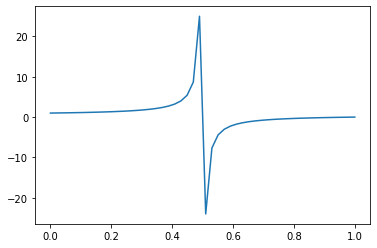

In [49]:
import matplotlib.pyplot as plt
import numpy as np
z = np.linspace(0,1)
plt.plot(z, (z - 1) / ( 2 * z - 1))

In [29]:
import cvxpy as cvx
x =  cvx.Variable(1)
y = cvx.Variable(1)
z = cvx.Variable(1)
l = cvx.Variable(1)

c = []
c += [x <= -1, y >= 1]
c += [l <= 1, 0 <= l]
c += [z == l * x + (1 - l) * y]
prob = cvx.Problem(cvx.Minimize(1), c)
prob.solve()

DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
var2 == var3 * var0 + (1.0 + -var3) * var1 , because the following subexpressions are not:
|--  var3 * var0
|--  (1.0 + -var3) * var1

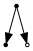

In [28]:
# by passing in different category classes, we can make polymorphic functions
# They have to have a uniform interface though, which is hard to constrain in python.
def polymorphic_prog(M):
    idd = M.idd()
    dump = M.dump()
    dup = M.dup()
    return (idd * dump) @ dup
poly_prog(GraphCat).run()

subgraph(G, nbunch)      - induced subgraph view of G on nodes in nbunch
union(G1,G2)             - graph union
disjoint_union(G1,G2)    - graph union assuming all nodes are different
cartesian_product(G1,G2) - return Cartesian product graph
compose(G1,G2)           - combine graphs identifying nodes common to both
complement(G)            - graph complement
create_empty_copy(G)     - return an empty copy of the same graph class
to_undirected(G) - return an undirected representation of G
to_directed(G) 

In [61]:
import networkx as nx
import random
def fresh(n):
    return list([random.randint(0,1e9) for i in range(n)])
'''
def mk_graph():
    G = nx.DiGraph()
    n = [random.randint() for i in range(10)]
    G.add_node(1)
    G.add_node(2)
    G.add_edge(1,2)
    return G
'''
def idd(n):
    def res():
        nodes = fresh(n)
        G = nx.DiGraph()
        G.add_nodes_from(nodes)
        return nodes, nodes, G
    return res
def compose(f,g):
    def res():
        a, b, Gf = f()
        b1, c, Gg = g()
        G = nx.union(Gf,Gg)
        G.add_edges_from(zip(b,b1))
        return a, c, G
    return res

630870925
668388471
730035531
174388255
362691729
714586520
509097511
12230588
630870925 362691729
668388471 714586520
730035531 509097511
174388255 12230588


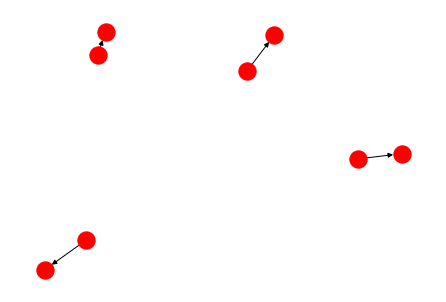

In [60]:
a, b , G = compose(idd(4),idd(4))()
nx.draw(G)
for n in G.nodes():
    print(n)
    
for a,b in G.edges():
    print(a,b)

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

AttributeError: 'NodeView' object has no attribute 'edges'

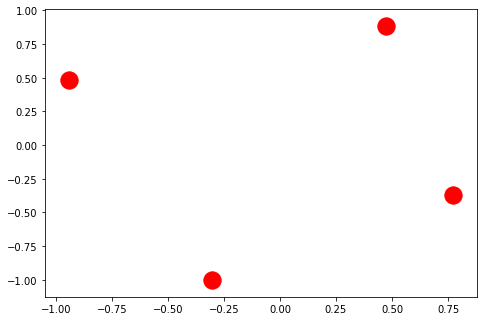

In [20]:

G1 = mk_graph()
G2 = mk_graph()
G3 = nx.disjoint_union(G1, G2).nodes()
nx.draw(G3)

In [ ]:
# inductive relations in z3

# inductive functions... 

# 

from z3 import *


